# Categorize Documents

In [111]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
import nltk
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import string

## Useful Links

### Scikit-Learn
[Scikit-Learn Documentation](http://scikit-learn.org/stable/user_guide.html)

### NLTK
[NLTK Book](http://www.nltk.org/book/)  
[NLTK API DOCS](http://www.nltk.org/api/nltk.html)  
[Module Index](http://www.nltk.org/py-modindex.html)

## Exploratory Analysis

In [2]:
df_train = pd.read_csv("training.csv")
df_dev = pd.read_csv("dev_testing.csv")
df_train.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,3,what was the first dvd you ever bought? what w...


Looks like class labels are disproportionately represented.  
*Possible actions*: different samples methods (stratified), make up more data, etc

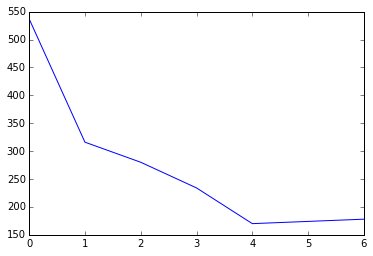

In [3]:
count_by_category = df_train.groupby("Category").count()
plt.plot(count_by_category)

## Feature Extraction

### Helper Functions

In [4]:
# Figure out the best feature extraction to use: http://scikit-learn.org/stable/modules/feature_extraction.html

def to_tokens(txt):
    pattern = r'''(?x)    # set flag to allow verbose regexps
        <
        | :
        | ([A-Z]\.)+        # abbreviations, e.g. U.S.A.
       | \w+([-']\w+)*        # words with optional internal hyphens
       | \$?\d+(\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
       | \.\.\.            # ellipsis
       | [.,;"'?():-_`]+  # these are separate tokens
     '''
    return nltk.regexp_tokenize(txt, pattern)

def remove_stopwords(wrds):
    stop_words = nltk.corpus.stopwords.words('english')
    return list(filter(lambda w: w.lower() not in stop_words, wrds))

def remove_punctuation(wrds):
    exclude = list(string.punctuation) + ["--","...", "`"]
    return list(filter(lambda w: w[0] not in exclude, wrds))

def remove_digits(wrds):
    exclude = list(string.digits)
    return list(filter(lambda w: w[0] not in exclude, wrds))

In [5]:
def build_count_features(dataset):
    vec = CountVectorizer(ngram_range=(1,3), token_pattern=r'\b\w+\b', min_df=2, max_features=1000)
    tokenizer = vec.build_tokenizer()
    arr_train_feature_sparse = vec.fit_transform(dataset["Text"])
    return arr_train_feature_sparse.toarray()

def remove_crap(dataset):
    d = dataset
    for i in range(0, len(dataset)):
        clean_tokens = remove_digits(remove_punctuation(remove_stopwords(to_tokens(d.iloc[i]["Text"]))))
        d.iloc[i]["Text"] = " ".join(clean_tokens)
    return d

def build_pos_tag_features(dataset):
    features = []
    for text in dataset["Text"]:
        clean_tokens = remove_digits(remove_punctuation(remove_stopwords(to_tokens(text))))
        feature = []
        
        grammar = r"""
          NP: {<NN.>}
        """
        cp = nltk.RegexpParser(grammar)
        tree = cp.parse(nltk.pos_tag((clean_tokens)))
        for token in tree.subtrees():
            # Add nouns as feature
            if token.label() == 'NP':
                feature.append(token[0])
        features.append(feature)
    return features

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4, stop_words="english", ngram_range=(1,2), max_features=1000)
train_features = vectorizer.fit_transform(df_train["Text"]).toarray()
dev_features = vectorizer.transform(df_dev["Text"]).toarray()

## Models

### Naive Bayes

In [117]:
nb = MultinomialNB()
nb_model = nb.fit(train_features, df_train["Category"])

nb_predictions = nb_model.predict(dev_features)
nb_predictions[0]

accuracy_score(df_dev["Category"], nb_predictions)

0.4857849196538937

## Evaluation

### Confusion Matrix

In [125]:
y_true = pd.Series(df_dev["Category"])
y_pred = pd.Series(nb_predictions)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,4,5,6,7,All
True,,,,,,,,
1,184,24,8,10,1,3,2,232
2,61,73,2,0,0,0,2,138
3,59,8,50,8,0,0,1,126
4,49,0,2,60,0,0,2,113
5,51,6,7,2,8,0,0,74
6,40,1,0,6,0,9,2,58
7,44,4,3,4,1,3,9,68
All,488,116,72,90,10,15,18,809


In [110]:
print("Actual", "Predicted", "Text", sep="-")
for i in range(0, len(df_dev)):
    if df_dev.ix[i]["Category"] != nb_predictions[i]:
        print(df_dev.ix[i]["Category"], nb_predictions[i], df_dev.ix[i]["Text"], sep="-")

Actual-Predicted-Text
3-1-do you watch movies multiple times? my husband &amp; i differ in a few areas
1-4-i can't find add contact on yahoo msg.  think don't have.? i'm trying to add a contact to my yahoo msg
3-1-how do you publish a song?
3-2-garfield
2-1-what is the best virus protection program to use that you do not have to keep purchasing upgrades for? please do not say norton's anti-virus as this is the one i want to replace!!!!
4-6-is it normal to want to have sex with other girls if you have a girlfriend? is it normal to want to have sex with a bunch of other girls even though you are in a relationship?  i was curious because everytime i look at another woman all i wanna do is her.  is that normal or do i have some kind of wanna have sex with all women disorder?
5-6-what is the best way to learn history?
3-1-who was famous for the line nanoo nanoo?
2-3-how can i save videos i watch using the real player onto my hard disk to watch them when i am offline? i tried the temporary f

## Prediction of the Test Set

In [101]:
df_test = pd.read_csv("newtest.csv")
dev_features = vectorizer.transform(df_test["Text"]).toarray()
nb_predictions = nb_model.predict(dev_features)
predictions = list(zip(df_test["Id"], nb_predictions))
predictions = pd.DataFrame(predictions)
predictions.columns = ["Id", "Category"]
predictions.to_csv("submission1.csv", index=False)